In [1]:
import pandas as pd
import numpy as np

#Set initial portfolio of bond's with credit ratings
initial_state = {
    'portfolio': pd.Series(["AAA"]*10+["AA"]*10+["A"]*10),
    'default': 0
}

In [2]:
#Credit transition matrix (yearly) from: https://www.msci.com/documents/10199/93396227-d449-4229-9143-24a94dab122f
transition_matrix = pd.DataFrame([[.9081, .0833,.0068,.0006,.0012,0,0,0],
                                 [.0070,.9065,.0779,.0064,.0006,.0014,.0002,0],
                                 [.0009,.0227,.9105,.0552,.0074,.0026,.0001,.0006],
                                 [.0002, .0033, .0595, .8693, .0530,.0117,.0012,.0018],
                                 [.0003, .0014,.0067,.0773,.8053,.0884, .0100, .0106],
                                 [0, .0011, .0024, .0043, .0648, .8346, .0407, .0521],
                                 [.0022, 0, .0022, .0130, .0238, .1124, .6486, .1978],
                                 [0,0,0,0,0,0,0,1]],
                                 index=["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Default"],
                                columns=["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Default"])

In [3]:
#Function to transition the matrix randomly
def credit_migration(_params, substep, sH, s):
    new_ratings = s['portfolio'].map(lambda x: np.random.choice(
  transition_matrix.index, 
  p=transition_matrix.loc[x].values))
    return {"ratings": new_ratings}

#Update the ratings    
def update_portfolio(_params, substep, sH, s, _input):
    return ('portfolio', _input['ratings'])

#Function to value the portfolio, for now just finding default %
def value_portfolio(_params, substep, sH, s):
    return {"default": (s['portfolio'] == "Default").sum() / len(s['portfolio'])}

#Update the value
def update_value(_params, substep, sH, s, _input):
    return ('default', _input['default'])

In [4]:
#Create partial updates
PSUBs = [
    {
        "policies": {
            "migration_policy": credit_migration,
        },
        "variables": {
            "portfolio": update_portfolio,
        }
    },
        {
        "policies": {
            "valuation_policy": value_portfolio,
        },
        "variables": {
            "default": update_value,
        }
    }
]

In [5]:
#Set parameters for 50 runs over 30 years
from cadCAD.configuration.utils import config_sim

sim_config_dict = {
    'T': range(30),
    'N': 50}
c = config_sim(sim_config_dict)


In [6]:
#Create experiment
from cadCAD.configuration import Experiment

exp = Experiment()
exp.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = PSUBs,
    sim_configs = c
)

In [7]:
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs

#Execute!
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.single_mode)
simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_result, field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (30, 1, 50, 2)
Execution Method: parallelize_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Ns       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
ExpIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

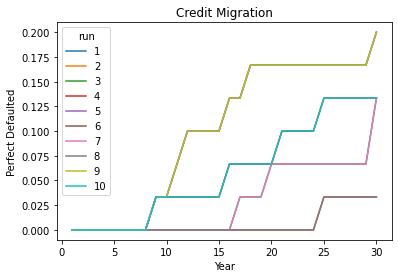

In [8]:
import matplotlib.pyplot as plt

default_rates = result[result['substep'] == 2].pivot('timestep', 'run', 'default')
default_rates.iloc[:,:10].plot(kind='line')
plt.xlabel("Year")
plt.ylabel("Perfect Defaulted")
plt.title("Credit Migration")
plt.show()

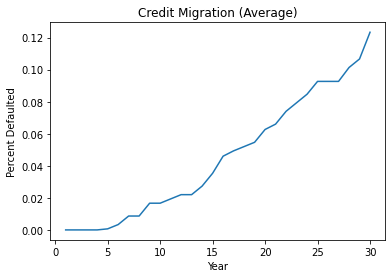

In [9]:
result[result['substep'] == 2].groupby("timestep")['default'].mean().plot(kind='line')
plt.xlabel("Year")
plt.ylabel("Percent Defaulted")
plt.title("Credit Migration (Average)")
plt.show()

In [10]:
#Find the predicted default rate based on markov chain
transition_matrices = [pd.DataFrame(np.diag([1]*8),index=transition_matrix.index, columns=transition_matrix.columns)]
for _ in range(30):
    transition_matrices.append(transition_matrices[-1].dot(transition_matrix))
    
predicted = pd.Series([1/3, 1/3, 1/3, 0, 0, 0, 0, 0], index=transition_matrix.index)
predicted = pd.Series([predicted.dot(x)['Default'] for x in transition_matrices],index=list(range(31)))
print(predicted)

0     0.000000
1     0.000200
2     0.000558
3     0.001107
4     0.001875
5     0.002885
6     0.004154
7     0.005697
8     0.007524
9     0.009641
10    0.012051
11    0.014756
12    0.017754
13    0.021042
14    0.024615
15    0.028466
16    0.032587
17    0.036971
18    0.041607
19    0.046486
20    0.051597
21    0.056930
22    0.062474
23    0.068217
24    0.074149
25    0.080258
26    0.086534
27    0.092965
28    0.099541
29    0.106251
30    0.113085
dtype: float64


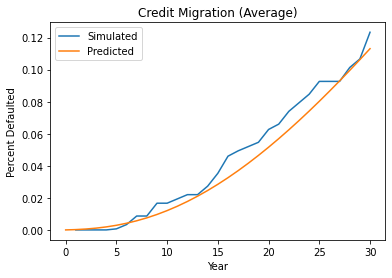

In [11]:
result[result['substep'] == 2].groupby("timestep")['default'].mean().plot(kind='line')
predicted.plot(kind='line')
plt.xlabel("Year")
plt.ylabel("Percent Defaulted")
plt.title("Credit Migration (Average)")
plt.legend(['Simulated', 'Predicted'])
plt.show()

In [12]:
#Convert to monthly transition matrix
u, V = np.linalg.eig(transition_matrix)
P = V
D = np.diag(u)
transition_matrix_monthly = pd.DataFrame(P.dot(D ** (1/12)).dot(np.linalg.inv(P)),
                                        index=["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Default"],
                                columns=["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "Default"])

#Get rid of the rounding error negative numbers
transition_matrix_monthly = transition_matrix_monthly.clip(0)
#Renormalize
transition_matrix_monthly = transition_matrix_monthly.multiply(1/transition_matrix_monthly.sum(axis=1), axis=0)

In [25]:
import pathos
pathos.helpers.shutdown()
configs.clear()

In [26]:
#Function to transition the matrix randomly, switch to monthly
def credit_migration(_params, substep, sH, s):
    new_ratings = s['portfolio'].map(lambda x: np.random.choice(
  transition_matrix_monthly.index, 
  p=transition_matrix_monthly.loc[x].values))
    return {"ratings": new_ratings}

#Update the ratings    
def update_portfolio(_params, substep, sH, s, _input):
    return ('portfolio', _input['ratings'])

#Function to value the portfolio, for now just finding default %
def value_portfolio(_params, substep, sH, s):
    return {"default": (s['portfolio'] == "Default").sum() / len(s['portfolio'])}

#Update the value
def update_value(_params, substep, sH, s, _input):
    return ('default', _input['default'])

#Create partial updates
PSUBs = [
    {
        "policies": {
            "migration_policy": credit_migration,
        },
        "variables": {
            "portfolio": update_portfolio,
        }
    },
        {
        "policies": {
            "valuation_policy": value_portfolio,
        },
        "variables": {
            "default": update_value,
        }
    }
]

sim_config_dict = {
    'T': range(360),
    'N': 50}
c = config_sim(sim_config_dict)

exp = Experiment()
exp.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = PSUBs,
    sim_configs = c
)

#Execute!
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.single_mode)
simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_result, field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (360, 1, 50, 2)
Execution Method: parallelize_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Ns       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
ExpIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [27]:
#Find the predicted default rate based on markov chain for monthly
transition_matrices = [pd.DataFrame(np.diag([1]*8),index=transition_matrix_monthly.index, columns=transition_matrix_monthly.columns)]
for _ in range(360):
    transition_matrices.append(transition_matrices[-1].dot(transition_matrix_monthly))

predicted = pd.Series([1/3, 1/3, 1/3, 0, 0, 0, 0, 0], index=transition_matrix_monthly.index)
predicted = pd.Series([predicted.dot(x)['Default'] for x in transition_matrices],index=list(range(361)))
print(predicted)

0      0.000000
1      0.000014
2      0.000029
3      0.000044
4      0.000061
         ...   
356    0.111732
357    0.112305
358    0.112879
359    0.113453
360    0.114029
Length: 361, dtype: float64


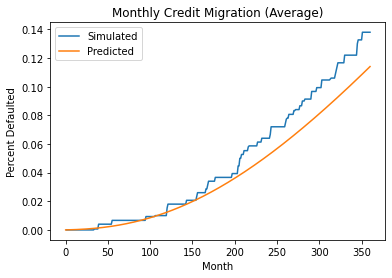

In [29]:
result[result['substep'] == 2].groupby("timestep")['default'].mean().plot(kind='line')
predicted.plot(kind='line')
plt.xlabel("Month")
plt.ylabel("Percent Defaulted")
plt.title("Monthly Credit Migration (Average)")
plt.legend(['Simulated', 'Predicted'])
plt.show()